In [2]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
from sklearn.metrics import mean_absolute_error
import os
import optuna
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import lightgbm as lgb
from sklearn.linear_model import ElasticNet

import csv
import os
import json
import numpy as np
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt

c:\Users\Mateo\Desktop\proye_borzo\MostoElMostro\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:

folder = '../data/processed'
filename = 'dataset_final.csv'
file_path = os.path.join(folder, filename)

try:
    df = pd.read_csv(
        file_path,
        sep=',',
        decimal='.'
    )
    df = df.sort_values(by='DIA', ignore_index=True)
    print(f"✅ DataFrame cargado exitosamente desde: {file_path}")
    print(f"Dimensiones: {df.shape}")
    print("\nPrimeras 5 filas:")
    print(df.head())

except FileNotFoundError:
    print(f"❌ Error: No se encontró el archivo en la ruta: {file_path}")
except Exception as e:
    print(f"❌ Error al leer el archivo: {e}")

✅ DataFrame cargado exitosamente desde: ../data/processed\dataset_final.csv
Dimensiones: (1181, 411)

Primeras 5 filas:
          DIA  EE Planta / Hl  EE Elaboracion / Hl  EE Bodega / Hl  \
0  2020-07-04        5.175639             0.439225        0.371077   
1  2020-07-05        7.924665             0.802365        0.717787   
2  2020-07-06        7.052766             0.685001        0.627064   
3  2020-07-07        6.531603             0.585813        0.550777   
4  2020-07-08        6.895979             0.695570        0.656979   

   EE Cocina / Hl  EE Envasado / Hl  EE Linea 2 / Hl  EE Linea 3 / Hl  \
0        0.258048          1.442114         4.348182         1.355238   
1        0.301592          1.664726         5.125920         2.704348   
2        0.287169          1.868486         4.262117         1.837734   
3        0.293204          1.904037         2.431647         1.560584   
4        0.259271          1.700085         2.370989         1.806340   

   EE Linea 4 / Hl  

In [4]:

# 1️⃣ Cargar dataset definitivo
ruta_csv = "../data/processed/X_test_preproc.csv"
X_test = pd.read_csv(ruta_csv, sep=',', decimal='.')
ruta_csv = "../data/processed/X_train_preproc.csv"
X_train = pd.read_csv(ruta_csv, sep=',', decimal='.')
ruta_csv = "../data/processed/y_test.csv"
y_test = pd.read_csv(ruta_csv, sep=',', decimal='.')
ruta_csv = "../data/processed/y_train.csv"
y_train = pd.read_csv(ruta_csv, sep=',', decimal='.')

y_train = y_train.iloc[:, 0].values.ravel()
y_test  = y_test.iloc[:, 0].values.ravel()

print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_test:", X_test.shape, "y_test:", y_test.shape)




X_train: (826, 40) y_train: (826,)
X_test: (355, 40) y_test: (355,)


In [6]:
def objective_rf_mae(trial):
    n_estimators = trial.suggest_int("n_estimators", 100, 1000, step=50)
    max_depth = trial.suggest_int("max_depth", 5, 50)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 20)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)
    max_features = trial.suggest_float("max_features", 0.1, 1.0, log=True)

    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        n_jobs=-1,
#        random_state=42
    )

    cv = KFold(n_splits=10, shuffle=True)
    fold_mae = []

    for fold_idx, (train_idx, val_idx) in enumerate(cv.split(X_train)):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train[train_idx], y_train[val_idx]

        model.fit(X_tr, y_tr)
        preds = model.predict(X_val)

        mae = mean_absolute_error(y_val, preds)
        fold_mae.append(mae)

        # Reportar al pruner
        trial.report(mae, fold_idx)

        # Podar si es necesario
        if trial.should_prune():
            raise optuna.TrialPruned()

    return np.mean(fold_mae)


In [5]:
def objective_xgb_mae(trial):
    model = xgb.XGBRegressor(
        n_estimators=trial.suggest_int("n_estimators", 100, 2000, step=100),
        learning_rate=trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        max_depth=trial.suggest_int("max_depth", 3, 10),
        subsample=trial.suggest_float("subsample", 0.6, 1.0, step=0.1),
        colsample_bytree=trial.suggest_float("colsample_bytree", 0.6, 1.0, step=0.1),
        reg_alpha=trial.suggest_float("reg_alpha", 1e-8, 1.0, log=True),
        reg_lambda=trial.suggest_float("reg_lambda", 1e-8, 1.0, log=True),
        n_jobs=-1,
#        random_state=42,
        verbosity=0
    )

    cv = KFold(n_splits=10, shuffle=True)
    fold_mae = []

    for fold_idx, (train_idx, val_idx) in enumerate(cv.split(X_train)):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train[train_idx], y_train[val_idx]

        model.fit(X_tr, y_tr)
        preds = model.predict(X_val)

        mae = mean_absolute_error(y_val, preds)
        fold_mae.append(mae)

        trial.report(mae, fold_idx)
        if trial.should_prune():
            raise optuna.TrialPruned()

    return np.mean(fold_mae)


In [6]:
def objective_lgbm_mae(trial):
    model = lgb.LGBMRegressor(
        n_estimators=trial.suggest_int("n_estimators", 100, 2000, step=100),
        learning_rate=trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        num_leaves=trial.suggest_int("num_leaves", 20, 150),
        subsample=trial.suggest_float("subsample", 0.6, 1.0, step=0.1),
        colsample_bytree=trial.suggest_float("colsample_bytree", 0.6, 1.0, step=0.1),
        reg_alpha=trial.suggest_float("reg_alpha", 1e-8, 1.0, log=True),
        reg_lambda=trial.suggest_float("reg_lambda", 1e-8, 1.0, log=True),
        n_jobs=-1,
    #    random_state=42,
        verbose=-1
    )

    cv = KFold(n_splits=10, shuffle=True)
    fold_mae = []

    for fold_idx, (train_idx, val_idx) in enumerate(cv.split(X_train)):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train[train_idx], y_train[val_idx]

        model.fit(X_tr, y_tr)
        preds = model.predict(X_val)

        mae = mean_absolute_error(y_val, preds)
        fold_mae.append(mae)

        trial.report(mae, fold_idx)
        if trial.should_prune():
            raise optuna.TrialPruned()

    return np.mean(fold_mae)


In [7]:
def objective_elasticnet_mae(trial):
    model = ElasticNet(
        alpha=trial.suggest_float("alpha", 1e-3, 10.0, log=True),
        l1_ratio=trial.suggest_float("l1_ratio", 0.0, 1.0),
#        random_state=42,
        max_iter=2000
    )

    cv = KFold(n_splits=10, shuffle=True)
    fold_mae = []

    for fold_idx, (train_idx, val_idx) in enumerate(cv.split(X_train)):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train[train_idx], y_train[val_idx]

        model.fit(X_tr, y_tr)
        preds = model.predict(X_val)

        mae = mean_absolute_error(y_val, preds)
        fold_mae.append(mae)

        trial.report(mae, fold_idx)
        if trial.should_prune():
            raise optuna.TrialPruned()

    return np.mean(fold_mae)


# 1. Crear los estudios (todos buscan minimizar el MAE)
study_rf_mae = optuna.create_study(direction="minimize")
study_xgb_mae = optuna.create_study(direction="minimize")
study_lgbm_mae = optuna.create_study(direction="minimize")
study_elasticnet_mae = optuna.create_study(direction="minimize")

# 2. Ejecutar las optimizaciones
print("Optimizando Random Forest (MAE)...")
study_rf_mae.optimize(objective_rf_mae, n_trials=50)

print("Optimizando XGBoost (MAE)...")
study_xgb_mae.optimize(objective_xgb_mae, n_trials=75)

print("Optimizando LightGBM (MAE)...")
study_lgbm_mae.optimize(objective_lgbm_mae, n_trials=75)

print("Optimizando ElasticNet (MAE)...")
study_elasticnet_mae.optimize(objective_elasticnet_mae, n_trials=40)

# 3. Ver los mejores parámetros
print(f"Mejor RF (MAE): {study_rf_mae.best_value} con params {study_rf_mae.best_params}")
print(f"Mejor XGB (MAE): {study_xgb_mae.best_value} con params {study_xgb_mae.best_params}")
print(f"Mejor LGBM (MAE): {study_lgbm_mae.best_value} con params {study_lgbm_mae.best_params}")
print(f"Mejor ElasticNet (MAE): {study_elasticnet_mae.best_value} con params {study_elasticnet_mae.best_params}")

In [ ]:

def log_experiment(model_name: str, 
                   model_object: object, 
                   study: optuna.study.Study, 
                   X_train, y_train, X_test, y_test):
    """
    Entrena un modelo con los mejores parámetros de un estudio de Optuna,
    calcula métricas y las guarda en un CSV.
    """
    
    # --- 1. Definir la ruta del log ---
    log_dir = "results"
    log_file = os.path.join(log_dir, "experiment_logs.csv")
    os.makedirs(log_dir, exist_ok=True) # Crea la carpeta si no existe

    # --- 2. Obtener mejores parámetros y valor del estudio ---
    best_params = study.best_params
    best_value = study.best_value # El MAE de CV que encontró Optuna
    
    # --- 3. Instanciar y entrenar el modelo final ---
    # Manejo especial para modelos lineales que necesitan Pipeline
    if "pipeline" in model_name.lower():
        # El pipeline ya está definido en la función objective, 
        # aquí solo re-creamos el mejor.
        if model_name == "Pipeline_ElasticNet":
             # Re-crea el pipeline con los mejores params
             model =ElasticNet(
                    alpha=best_params.get('alpha'), 
                    l1_ratio=best_params.get('l1_ratio'),
                    random_state=42, 
                    max_iter=2000
                )
            
            
    else:
        # Para modelos no-pipeline (RF, XGB, LGBM)
        model = model_object(**best_params, random_state=42, n_jobs=-1)
        # Ajustes para modelos que no les gusta 'n_jobs' o necesitan 'verbose'
        if isinstance(model, (xgb.XGBRegressor, lgb.LGBMRegressor)):
            model.set_params(verbosity=0) if isinstance(model, xgb.XGBRegressor) else None
            model.set_params(verbose=-1) if isinstance(model, lgb.LGBMRegressor) else None

    # Entrenar el modelo final con todos los datos de train
    model.fit(X_train, y_train)

    # --- 4. Calcular Métricas (Train y Test) ---
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    metrics = {
        'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
        'model_name': model_name,
        'optuna_cv_mae': best_value, # Métrica optimizada
        'mae_train': mean_absolute_error(y_train, y_pred_train),
        'mae_test': mean_absolute_error(y_test, y_pred_test),
        'rmse_train': np.sqrt(mean_squared_error(y_train, y_pred_train)),
        'rmse_test': np.sqrt(mean_squared_error(y_test, y_pred_test)),
        'r2_train': r2_score(y_train, y_pred_train),
        'r2_test': r2_score(y_test, y_pred_test),
        'hyperparameters': json.dumps(best_params) # Guardar params como string JSON
    }
    
    # --- 5. Escribir en el CSV ---
    file_exists = os.path.isfile(log_file)
    
    with open(log_file, 'a', newline='', encoding='utf-8') as f:
        writer = csv.DictWriter(f, fieldnames=metrics.keys())
        
        if not file_exists:
            writer.writeheader() # Escribir cabecera solo si el archivo es nuevo
            
        writer.writerow(metrics)
        
    print(f"Resultados de '{model_name}' guardados en {log_file}")

In [8]:
# --- 1. Ejecutar el estudio (ejemplo con Random Forest) ---
print("Optimizando Random Forest (MAE)...")
study_rf_mae = optuna.create_study(direction="minimize", pruner=optuna.pruners.MedianPruner(n_warmup_steps=5))
# (Aquí asumimos que 'objective_rf_mae' está definida)
study_rf_mae.optimize(objective_rf_mae, n_trials=100) 

# --- 2. Registrar el resultado ---
log_experiment(
    model_name="RandomForest",
    model_object=RandomForestRegressor, # Pasa la clase del modelo
    study=study_rf_mae,
    X_train=X_train, y_train=y_train,
    X_test=X_test, y_test=y_test
)

# --- 3. Ejecutar el estudio (ejemplo con XGBoost) ---


[I 2025-11-17 01:52:39,551] A new study created in memory with name: no-name-b748b269-b0ec-47dc-aa5b-aee183831b6f


Optimizando Random Forest (MAE)...


[I 2025-11-17 01:52:46,026] Trial 0 finished with value: 10177.429125658116 and parameters: {'n_estimators': 550, 'max_depth': 24, 'min_samples_split': 15, 'min_samples_leaf': 4, 'max_features': 0.9001734760090996}. Best is trial 0 with value: 10177.429125658116.
[I 2025-11-17 01:52:50,665] Trial 1 finished with value: 9896.921419704948 and parameters: {'n_estimators': 500, 'max_depth': 25, 'min_samples_split': 8, 'min_samples_leaf': 7, 'max_features': 0.5062876720937084}. Best is trial 1 with value: 9896.921419704948.
[I 2025-11-17 01:52:53,246] Trial 2 finished with value: 9962.738712707865 and parameters: {'n_estimators': 300, 'max_depth': 21, 'min_samples_split': 17, 'min_samples_leaf': 4, 'max_features': 0.22480866808468022}. Best is trial 1 with value: 9896.921419704948.
[I 2025-11-17 01:52:59,845] Trial 3 finished with value: 10454.477438769462 and parameters: {'n_estimators': 750, 'max_depth': 49, 'min_samples_split': 17, 'min_samples_leaf': 3, 'max_features': 0.375292092270737

NameError: name 'log_experiment' is not defined

Métricas del modelo de test:
R²:   0.2019
MAE:  3774.9272
RMSE: 27402626.2616


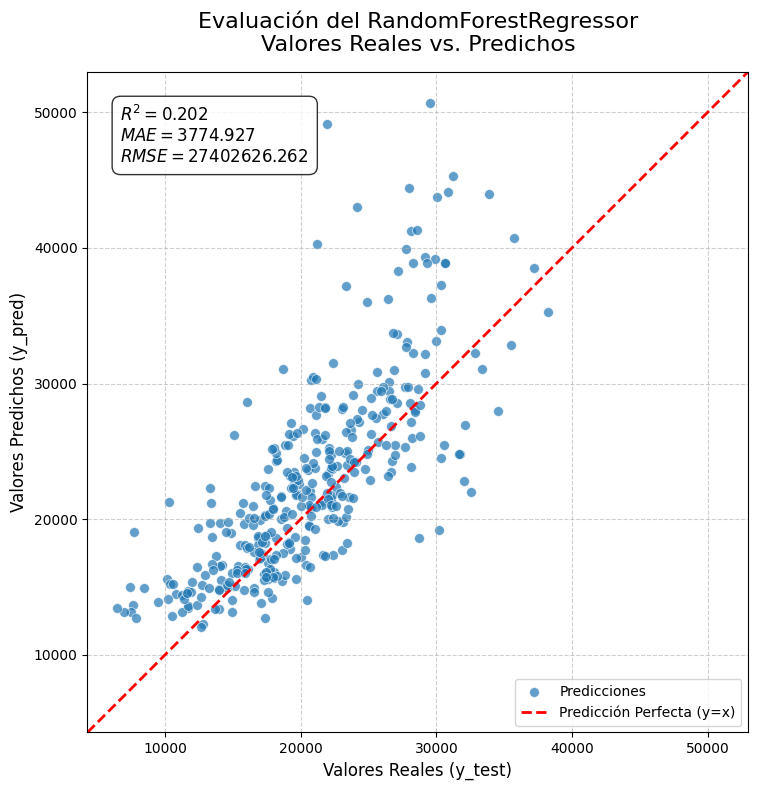

In [20]:
parameters = study_rf_mae.best_params
model = RandomForestRegressor(**parameters)
model.fit(X_train, y_train)
y_pred_test = model.predict(X_test)

# --- Mejoras del gráfico ---

# 1. Calcular métricas clave
mae = mean_absolute_error(y_test, y_pred_test)
rmse = mean_squared_error(y_test, y_pred_test) # squared=False para obtener RMSE
r2 = r2_score(y_test, y_pred_test)

print(f"Métricas del modelo de test:")
print(f"R²:   {r2:.4f}")
print(f"MAE:  {mae:.4f}")
print(f"RMSE: {rmse:.4f}")

# 2. Crear la figura
plt.figure(figsize=(10, 8))

# 3. Crear el scatter plot (con transparencia para ver la densidad)
ax = sns.scatterplot(x=y_test, y=y_pred_test, alpha=0.7, s=50, label="Predicciones")

# 4. Añadir la línea de predicción perfecta (y=x)
# Obtenemos los límites de los ejes
min_val = min(y_test.min(), y_pred_test.min())
max_val = max(y_test.max(), y_pred_test.max())
# Añadimos un pequeño margen
min_val = min_val - (max_val - min_val) * 0.05
max_val = max_val + (max_val - min_val) * 0.05

ax.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label="Predicción Perfecta (y=x)")

# 5. Configuración de etiquetas y título
ax.set_xlabel("Valores Reales (y_test)", fontsize=12)
ax.set_ylabel("Valores Predichos (y_pred)", fontsize=12)
ax.set_title(f"Evaluación del RandomForestRegressor\nValores Reales vs. Predichos", fontsize=16, pad=15)

# 6. Forzar aspecto cuadrado para que la línea de 45° se vea correcta
ax.set_aspect('equal', adjustable='box')
ax.set_xlim(min_val, max_val)
ax.set_ylim(min_val, max_val)

# 7. Añadir las métricas como texto dentro del gráfico
# (usamos ax.transAxes para posicionar el texto en coordenadas relativas)
text_str = f"$R^2 = {r2:.3f}$\n$MAE = {mae:.3f}$\n$RMSE = {rmse:.3f}$"
ax.text(0.05, 0.95, text_str, transform=ax.transAxes, fontsize=12,
        verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.8))

# 8. Añadir leyenda y grid
ax.legend(loc='lower right')
ax.grid(True, linestyle='--', alpha=0.6)

# 9. Mostrar el gráfico
plt.tight_layout()
plt.show()

In [11]:

# --- 5. Ejecutar el estudio (ejemplo con ElasticNet) ---
print("Optimizando ElasticNet (MAE)...")
study_elasticnet_mae = optuna.create_study(direction="minimize", pruner=optuna.pruners.MedianPruner(n_warmup_steps=5))
# (Aquí asumimos que 'objective_elasticnet_mae' está definida)
study_elasticnet_mae.optimize(objective_elasticnet_mae, n_trials=100)

# --- 6. Registrar el resultado ---
# Nota: 'model_object' es None porque se maneja dentro del 'if'
log_experiment(
    model_name="Pipeline_ElasticNet",
    model_object=None, 
    study=study_elasticnet_mae,
    X_train=X_train, y_train=y_train,
    X_test=X_test, y_test=y_test
)


[I 2025-11-16 19:36:30,398] A new study created in memory with name: no-name-bbbba1c2-9f7a-483f-832e-62b5b45e0db1
[I 2025-11-16 19:36:30,581] Trial 0 finished with value: 19275.8728305666 and parameters: {'alpha': 0.06343910810290329, 'l1_ratio': 0.8208623376025478}. Best is trial 0 with value: 19275.8728305666.


Optimizando ElasticNet (MAE)...


[I 2025-11-16 19:36:30,602] Trial 1 finished with value: 8342.566400757898 and parameters: {'alpha': 7.8887588836468545, 'l1_ratio': 0.09293552799536442}. Best is trial 1 with value: 8342.566400757898.
[I 2025-11-16 19:36:30,658] Trial 2 finished with value: 13801.383844399184 and parameters: {'alpha': 0.13563937887738323, 'l1_ratio': 0.07429568721164936}. Best is trial 1 with value: 8342.566400757898.
[I 2025-11-16 19:36:30,686] Trial 3 finished with value: 10664.128219855487 and parameters: {'alpha': 0.756731157014376, 'l1_ratio': 0.08584528885545784}. Best is trial 1 with value: 8342.566400757898.
[I 2025-11-16 19:36:30,779] Trial 4 finished with value: 16471.104578078244 and parameters: {'alpha': 0.15429096961358335, 'l1_ratio': 0.786890161965395}. Best is trial 1 with value: 8342.566400757898.
c:\Users\Mateo\Desktop\proye_borzo\MostoElMostro\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to in

Resultados de 'Pipeline_ElasticNet' guardados en results\experiment_logs.csv


Métricas del modelo de test:
R²:   0.5585
MAE:  3002.4618
RMSE: 15157782.4833


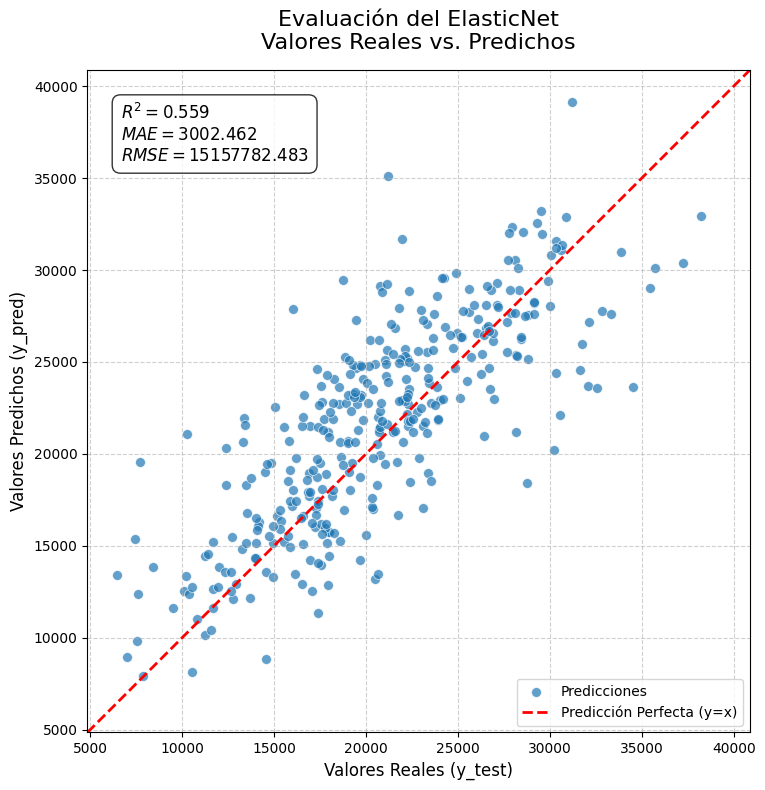

In [21]:
parameters = study_elasticnet_mae.best_params
model = ElasticNet(**parameters)
model.fit(X_train, y_train)
y_pred_test = model.predict(X_test)

# --- Mejoras del gráfico ---

# 1. Calcular métricas clave
mae = mean_absolute_error(y_test, y_pred_test)
rmse = mean_squared_error(y_test, y_pred_test) # squared=False para obtener RMSE
r2 = r2_score(y_test, y_pred_test)

print(f"Métricas del modelo de test:")
print(f"R²:   {r2:.4f}")
print(f"MAE:  {mae:.4f}")
print(f"RMSE: {rmse:.4f}")

# 2. Crear la figura
plt.figure(figsize=(10, 8))

# 3. Crear el scatter plot (con transparencia para ver la densidad)
ax = sns.scatterplot(x=y_test, y=y_pred_test, alpha=0.7, s=50, label="Predicciones")

# 4. Añadir la línea de predicción perfecta (y=x)
# Obtenemos los límites de los ejes
min_val = min(y_test.min(), y_pred_test.min())
max_val = max(y_test.max(), y_pred_test.max())
# Añadimos un pequeño margen
min_val = min_val - (max_val - min_val) * 0.05
max_val = max_val + (max_val - min_val) * 0.05

ax.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label="Predicción Perfecta (y=x)")

# 5. Configuración de etiquetas y título
ax.set_xlabel("Valores Reales (y_test)", fontsize=12)
ax.set_ylabel("Valores Predichos (y_pred)", fontsize=12)
ax.set_title(f"Evaluación del ElasticNet\nValores Reales vs. Predichos", fontsize=16, pad=15)

# 6. Forzar aspecto cuadrado para que la línea de 45° se vea correcta
ax.set_aspect('equal', adjustable='box')
ax.set_xlim(min_val, max_val)
ax.set_ylim(min_val, max_val)

# 7. Añadir las métricas como texto dentro del gráfico
# (usamos ax.transAxes para posicionar el texto en coordenadas relativas)
text_str = f"$R^2 = {r2:.3f}$\n$MAE = {mae:.3f}$\n$RMSE = {rmse:.3f}$"
ax.text(0.05, 0.95, text_str, transform=ax.transAxes, fontsize=12,
        verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.8))

# 8. Añadir leyenda y grid
ax.legend(loc='lower right')
ax.grid(True, linestyle='--', alpha=0.6)

# 9. Mostrar el gráfico
plt.tight_layout()
plt.show()

In [12]:
print("Optimizando XGBoost (MAE)...")
study_xgb_mae = optuna.create_study(direction="minimize", pruner=optuna.pruners.MedianPruner(n_warmup_steps=5))
# (Aquí asumimos que 'objective_xgb_mae' está definida)
study_xgb_mae.optimize(objective_xgb_mae, n_trials=50)

# --- 4. Registrar el resultado ---
log_experiment(
    model_name="XGBoost",
    model_object=xgb.XGBRegressor, # Pasa la clase del modelo
    study=study_xgb_mae,
    X_train=X_train, y_train=y_train,
    X_test=X_test, y_test=y_test
)



[I 2025-11-16 19:36:34,154] A new study created in memory with name: no-name-74f5a7eb-d354-4e3f-8567-8b3878896177


Optimizando XGBoost (MAE)...


[I 2025-11-16 19:36:57,629] Trial 0 finished with value: 10131.15901517656 and parameters: {'n_estimators': 1400, 'learning_rate': 0.12203577585169234, 'max_depth': 8, 'subsample': 1.0, 'colsample_bytree': 0.7, 'reg_alpha': 0.039568285513595404, 'reg_lambda': 0.008434861097530425}. Best is trial 0 with value: 10131.15901517656.
[I 2025-11-16 19:37:22,099] Trial 1 finished with value: 16346.805709822429 and parameters: {'n_estimators': 1200, 'learning_rate': 0.24816580706043337, 'max_depth': 10, 'subsample': 0.7, 'colsample_bytree': 0.7, 'reg_alpha': 8.436950104985828e-07, 'reg_lambda': 0.027170167709855596}. Best is trial 0 with value: 10131.15901517656.
[I 2025-11-16 19:37:46,224] Trial 2 finished with value: 13801.641231472671 and parameters: {'n_estimators': 1900, 'learning_rate': 0.09247556095348655, 'max_depth': 7, 'subsample': 0.8, 'colsample_bytree': 0.8, 'reg_alpha': 0.00046761512592967955, 'reg_lambda': 0.00038723645267604807}. Best is trial 0 with value: 10131.15901517656.
[I

Resultados de 'XGBoost' guardados en results\experiment_logs.csv


Métricas del modelo de test:
R²:   0.5140
MAE:  3168.1278
RMSE: 16687519.3506


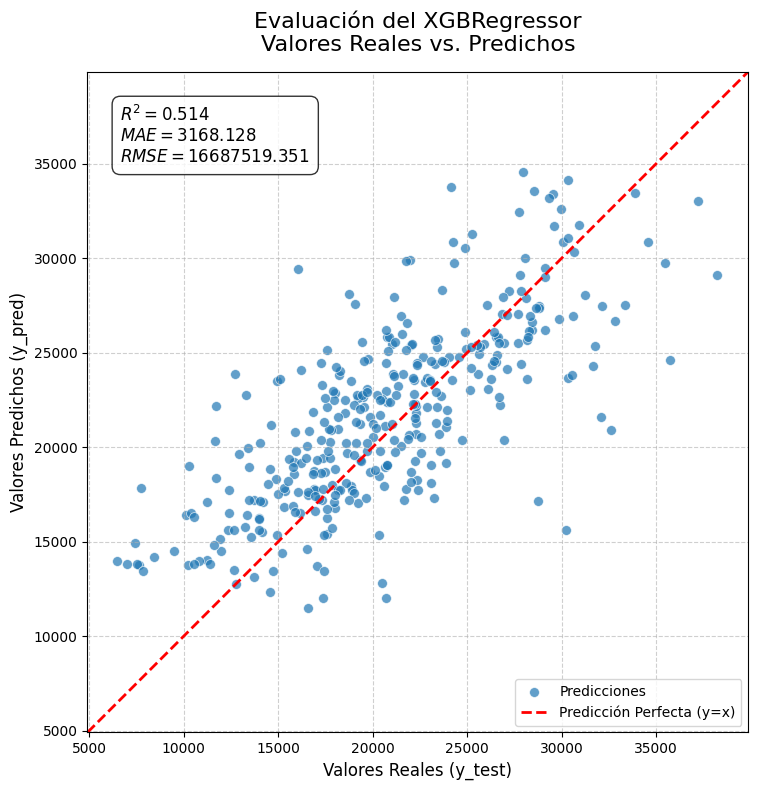

In [22]:
parameters = study_xgb_mae.best_params
model = xgb.XGBRegressor(**parameters)
model.fit(X_train, y_train)
y_pred_test = model.predict(X_test)

# --- Mejoras del gráfico ---

# 1. Calcular métricas clave
mae = mean_absolute_error(y_test, y_pred_test)
rmse = mean_squared_error(y_test, y_pred_test) # squared=False para obtener RMSE
r2 = r2_score(y_test, y_pred_test)

print(f"Métricas del modelo de test:")
print(f"R²:   {r2:.4f}")
print(f"MAE:  {mae:.4f}")
print(f"RMSE: {rmse:.4f}")

# 2. Crear la figura
plt.figure(figsize=(10, 8))

# 3. Crear el scatter plot (con transparencia para ver la densidad)
ax = sns.scatterplot(x=y_test, y=y_pred_test, alpha=0.7, s=50, label="Predicciones")

# 4. Añadir la línea de predicción perfecta (y=x)
# Obtenemos los límites de los ejes
min_val = min(y_test.min(), y_pred_test.min())
max_val = max(y_test.max(), y_pred_test.max())
# Añadimos un pequeño margen
min_val = min_val - (max_val - min_val) * 0.05
max_val = max_val + (max_val - min_val) * 0.05

ax.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label="Predicción Perfecta (y=x)")

# 5. Configuración de etiquetas y título
ax.set_xlabel("Valores Reales (y_test)", fontsize=12)
ax.set_ylabel("Valores Predichos (y_pred)", fontsize=12)
ax.set_title(f"Evaluación del XGBRegressor\nValores Reales vs. Predichos", fontsize=16, pad=15)

# 6. Forzar aspecto cuadrado para que la línea de 45° se vea correcta
ax.set_aspect('equal', adjustable='box')
ax.set_xlim(min_val, max_val)
ax.set_ylim(min_val, max_val)

# 7. Añadir las métricas como texto dentro del gráfico
# (usamos ax.transAxes para posicionar el texto en coordenadas relativas)
text_str = f"$R^2 = {r2:.3f}$\n$MAE = {mae:.3f}$\n$RMSE = {rmse:.3f}$"
ax.text(0.05, 0.95, text_str, transform=ax.transAxes, fontsize=12,
        verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.8))

# 8. Añadir leyenda y grid
ax.legend(loc='lower right')
ax.grid(True, linestyle='--', alpha=0.6)

# 9. Mostrar el gráfico
plt.tight_layout()
plt.show()

In [24]:
# --- 5. Ejecutar el estudio (ejemplo con LGBM) ---
print("Optimizando LightGBM (MAE)...")
study_lgbm_mae = optuna.create_study(direction="minimize", pruner=optuna.pruners.MedianPruner(n_warmup_steps=5))
study_lgbm_mae.optimize(objective_lgbm_mae, n_trials=30)

# --- 6. Registrar el resultado ---
log_experiment(
    model_name="LightGBM",
    model_object=lgb.LGBMRegressor,  # Pasamos la clase del modelo
    study=study_lgbm_mae,
    X_train=X_train, y_train=y_train,
    X_test=X_test, y_test=y_test
)


[I 2025-11-16 20:04:35,858] A new study created in memory with name: no-name-1e1e6b54-f0f6-4f35-a807-52836f83648d


Optimizando LightGBM (MAE)...


[I 2025-11-16 20:04:42,921] Trial 0 finished with value: 12277.79737240417 and parameters: {'n_estimators': 1100, 'learning_rate': 0.010739037535526894, 'num_leaves': 128, 'subsample': 1.0, 'colsample_bytree': 0.9, 'reg_alpha': 2.261679239422572e-07, 'reg_lambda': 4.047188345966781e-06}. Best is trial 0 with value: 12277.79737240417.
[I 2025-11-16 20:04:52,917] Trial 1 finished with value: 18375.20304026257 and parameters: {'n_estimators': 1600, 'learning_rate': 0.0256068701360275, 'num_leaves': 34, 'subsample': 0.7, 'colsample_bytree': 0.7, 'reg_alpha': 0.0008450080310374022, 'reg_lambda': 0.17547291485724975}. Best is trial 0 with value: 12277.79737240417.
[I 2025-11-16 20:05:02,460] Trial 2 finished with value: 23361.783742158932 and parameters: {'n_estimators': 1400, 'learning_rate': 0.08501455982591105, 'num_leaves': 42, 'subsample': 0.7, 'colsample_bytree': 1.0, 'reg_alpha': 0.07378556383403626, 'reg_lambda': 0.0007706102800997595}. Best is trial 0 with value: 12277.79737240417.


Resultados de 'LightGBM' guardados en results\experiment_logs.csv


Métricas del modelo de test:
R²:   0.2020
MAE:  3663.3150
RMSE: 27399625.5541


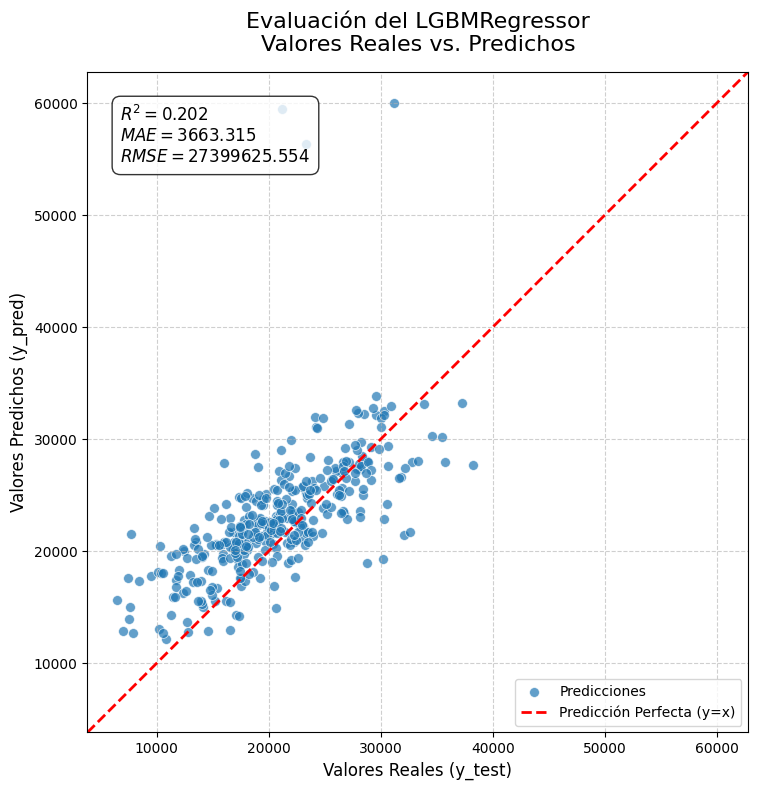

In [25]:
parameters = study_lgbm_mae.best_params
model = lgb.LGBMRegressor(**parameters)
model.fit(X_train, y_train)
y_pred_test = model.predict(X_test)

# --- Mejoras del gráfico ---

# 1. Calcular métricas clave
mae = mean_absolute_error(y_test, y_pred_test)
rmse = mean_squared_error(y_test, y_pred_test) # squared=False para obtener RMSE
r2 = r2_score(y_test, y_pred_test)

print(f"Métricas del modelo de test:")
print(f"R²:   {r2:.4f}")
print(f"MAE:  {mae:.4f}")
print(f"RMSE: {rmse:.4f}")

# 2. Crear la figura
plt.figure(figsize=(10, 8))

# 3. Crear el scatter plot (con transparencia para ver la densidad)
ax = sns.scatterplot(x=y_test, y=y_pred_test, alpha=0.7, s=50, label="Predicciones")

# 4. Añadir la línea de predicción perfecta (y=x)
# Obtenemos los límites de los ejes
min_val = min(y_test.min(), y_pred_test.min())
max_val = max(y_test.max(), y_pred_test.max())
# Añadimos un pequeño margen
min_val = min_val - (max_val - min_val) * 0.05
max_val = max_val + (max_val - min_val) * 0.05

ax.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label="Predicción Perfecta (y=x)")

# 5. Configuración de etiquetas y título
ax.set_xlabel("Valores Reales (y_test)", fontsize=12)
ax.set_ylabel("Valores Predichos (y_pred)", fontsize=12)
ax.set_title(f"Evaluación del LGBMRegressor\nValores Reales vs. Predichos", fontsize=16, pad=15)

# 6. Forzar aspecto cuadrado para que la línea de 45° se vea correcta
ax.set_aspect('equal', adjustable='box')
ax.set_xlim(min_val, max_val)
ax.set_ylim(min_val, max_val)

# 7. Añadir las métricas como texto dentro del gráfico
# (usamos ax.transAxes para posicionar el texto en coordenadas relativas)
text_str = f"$R^2 = {r2:.3f}$\n$MAE = {mae:.3f}$\n$RMSE = {rmse:.3f}$"
ax.text(0.05, 0.95, text_str, transform=ax.transAxes, fontsize=12,
        verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.8))

# 8. Añadir leyenda y grid
ax.legend(loc='lower right')
ax.grid(True, linestyle='--', alpha=0.6)

# 9. Mostrar el gráfico
plt.tight_layout()
plt.show()

In [29]:
            
# Entrenar el modelo final con todos los datos de train
model = RandomForestRegressor(n_estimators=750, max_depth=39, min_samples_split=19, min_samples_leaf=4, max_features=0.7682538772226404)
model.fit(X_train, y_train)

 # --- 4. Calcular Métricas (Train y Test) ---
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)
    
metrics = {
        'mae_train': mean_absolute_error(y_train, y_pred_train),
        'mae_test': mean_absolute_error(y_test, y_pred_test),
        'rmse_train': np.sqrt(mean_squared_error(y_train, y_pred_train)),
        'rmse_test': np.sqrt(mean_squared_error(y_test, y_pred_test)),
        'r2_train': r2_score(y_train, y_pred_train),
        'r2_test': r2_score(y_test, y_pred_test),
    }

print(metrics)

{'mae_train': 7887.067752326292, 'mae_test': 2931.1508963490173, 'rmse_train': np.float64(86261.73043597984), 'rmse_test': np.float64(3792.7826832269666), 'r2_train': 0.2068767185857353, 'r2_test': 0.5810371249424833}


Métricas del modelo de test:
R²:   0.5810
MAE:  2931.1509
RMSE: 14385200.4822


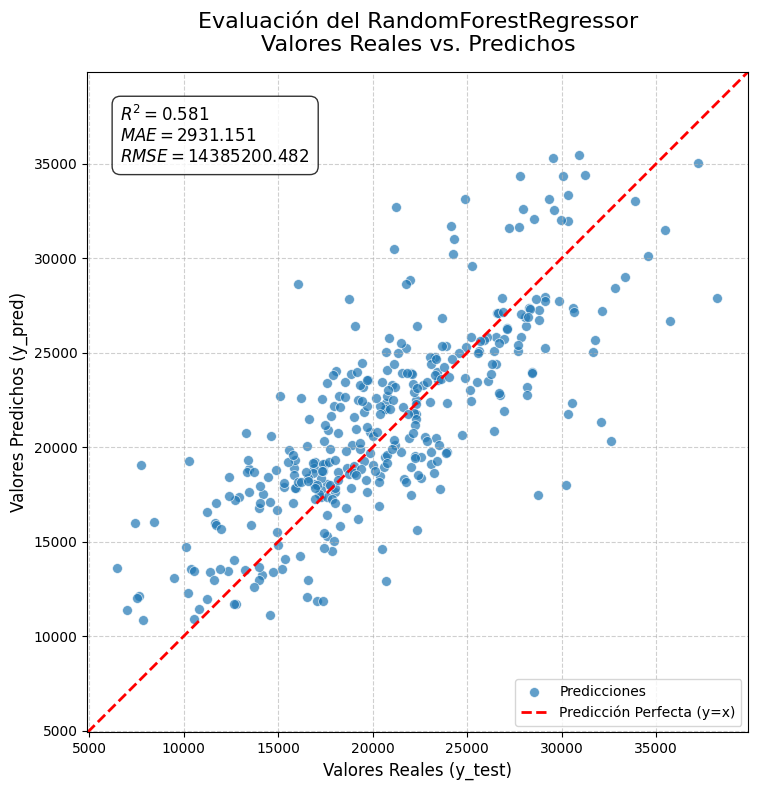

In [31]:

# --- Mejoras del gráfico ---

# 1. Calcular métricas clave
mae = mean_absolute_error(y_test, y_pred_test)
rmse = mean_squared_error(y_test, y_pred_test) # squared=False para obtener RMSE
r2 = r2_score(y_test, y_pred_test)

print(f"Métricas del modelo de test:")
print(f"R²:   {r2:.4f}")
print(f"MAE:  {mae:.4f}")
print(f"RMSE: {rmse:.4f}")

# 2. Crear la figura
plt.figure(figsize=(10, 8))

# 3. Crear el scatter plot (con transparencia para ver la densidad)
ax = sns.scatterplot(x=y_test, y=y_pred_test, alpha=0.7, s=50, label="Predicciones")

# 4. Añadir la línea de predicción perfecta (y=x)
# Obtenemos los límites de los ejes
min_val = min(y_test.min(), y_pred_test.min())
max_val = max(y_test.max(), y_pred_test.max())
# Añadimos un pequeño margen
min_val = min_val - (max_val - min_val) * 0.05
max_val = max_val + (max_val - min_val) * 0.05

ax.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label="Predicción Perfecta (y=x)")

# 5. Configuración de etiquetas y título
ax.set_xlabel("Valores Reales (y_test)", fontsize=12)
ax.set_ylabel("Valores Predichos (y_pred)", fontsize=12)
ax.set_title(f"Evaluación del RandomForestRegressor\nValores Reales vs. Predichos", fontsize=16, pad=15)

# 6. Forzar aspecto cuadrado para que la línea de 45° se vea correcta
ax.set_aspect('equal', adjustable='box')
ax.set_xlim(min_val, max_val)
ax.set_ylim(min_val, max_val)

# 7. Añadir las métricas como texto dentro del gráfico
# (usamos ax.transAxes para posicionar el texto en coordenadas relativas)
text_str = f"$R^2 = {r2:.3f}$\n$MAE = {mae:.3f}$\n$RMSE = {rmse:.3f}$"
ax.text(0.05, 0.95, text_str, transform=ax.transAxes, fontsize=12,
        verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.8))

# 8. Añadir leyenda y grid
ax.legend(loc='lower right')
ax.grid(True, linestyle='--', alpha=0.6)

# 9. Mostrar el gráfico
plt.tight_layout()
plt.show()

In [27]:
from scipy.stats import f_oneway

Analizando hiperparámetros encontrados: ['max_depth', 'max_features', 'min_samples_leaf', 'min_samples_split', 'n_estimators']
Skipping ANOVA for 'max_features' (no hay suficientes grupos para comparar)


C:\Users\Mateo\AppData\Local\Temp\ipykernel_18756\1419785667.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="F-statistic", y="param", data=anova_df, palette="viridis")


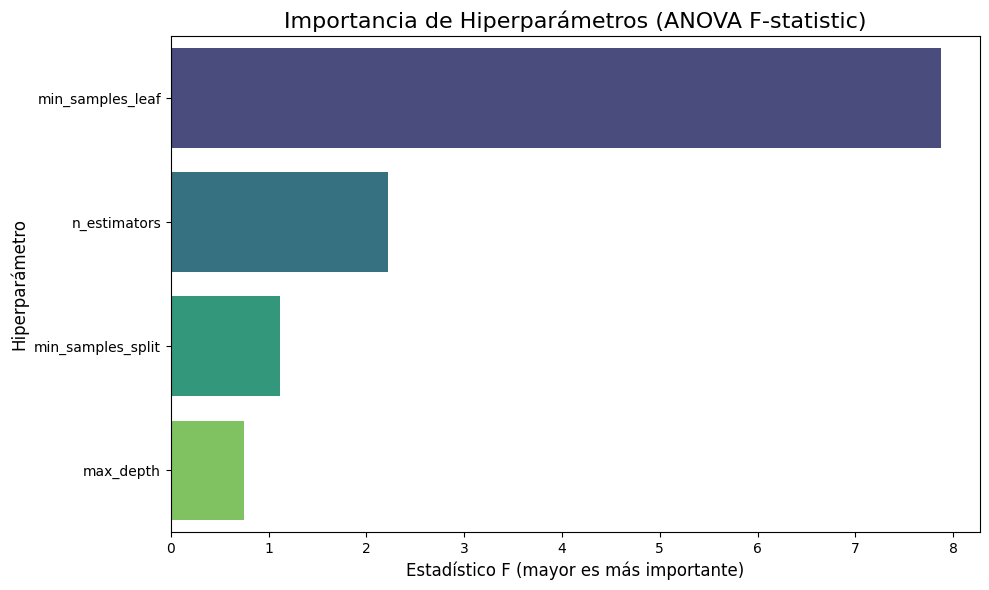


Resultados del ANOVA:
               param  F-statistic       p-value
1   min_samples_leaf     7.880717  7.142967e-08
3       n_estimators     2.219587  1.097390e-02
2  min_samples_split     1.118796  3.591936e-01
0          max_depth     0.749409  7.465516e-01


In [28]:
df_trials = study_rf_mae.trials_dataframe(attrs=("number", "value", "params", "state"))

# Filtramos solo los trials completados (por si alguno falló)
df_trials = df_trials[df_trials["state"] == "COMPLETE"]

# Identificamos automáticamente los hiperparámetros probados
# Serán columnas que empiecen con "params_"
param_cols = [col for col in df_trials.columns if col.startswith("params_")]
# Extraemos el nombre limpio (ej. "params_n_estimators" -> "n_estimators")
param_names = [col.replace("params_", "") for col in param_cols]

anova_results = {}
print(f"Analizando hiperparámetros encontrados: {param_names}")

# Iteramos sobre los parámetros que encontramos
for param_name, param_col in zip(param_names, param_cols):
    grupos = []
    
    # Agrupamos los 'values' (MAE) por cada valor único del hiperparámetro
    # .dropna() es importante por si Optuna no probó un param en algún trial
    unique_vals = df_trials[param_col].dropna().unique()

    for val in unique_vals:
        subset = df_trials[df_trials[param_col] == val]["value"]
        # Nos aseguramos que haya suficientes datos para el test
        if len(subset) > 1:
            grupos.append(subset.values)
    
    # Comprobamos si tenemos al menos 2 grupos para comparar
    if len(grupos) > 1:
        try:
            stat, pval = f_oneway(*grupos)
            anova_results[param_name] = (stat, pval)
        except ValueError as e:
            print(f"No se pudo calcular ANOVA para '{param_name}': {e}")
    else:
        print(f"Skipping ANOVA for '{param_name}' (no hay suficientes grupos para comparar)")

# --- 3. Tu código de Ploteo (con una pequeña mejora) ---

if anova_results: # Solo si pudimos calcular algo
    # Pasamos a DataFrame para graficar
    anova_df = pd.DataFrame([
        {"param": k, "F-statistic": v[0], "p-value": v[1]}
        for k, v in anova_results.items()
    ])
    
    # MEJORA: Ordenamos para que el gráfico sea más legible
    anova_df = anova_df.sort_values(by="F-statistic", ascending=False)

    plt.figure(figsize=(10, 6)) # Un poco más grande
    sns.barplot(x="F-statistic", y="param", data=anova_df, palette="viridis")
    plt.title("Importancia de Hiperparámetros (ANOVA F-statistic)", fontsize=16)
    plt.xlabel("Estadístico F (mayor es más importante)", fontsize=12)
    plt.ylabel("Hiperparámetro", fontsize=12)
    plt.tight_layout()
    plt.show()
    
    # También podemos ver los p-values
    print("\nResultados del ANOVA:")
    print(anova_df)
    
else:
    print("No se generaron resultados de ANOVA.")


--- Generando Gráfico de Importancia de Features Global ---
Entrenando modelo final con params: {'n_estimators': 250, 'max_depth': 9, 'min_samples_split': 20, 'min_samples_leaf': 6, 'max_features': 0.10067085334928469}
Modelo final entrenado.


C:\Users\Mateo\AppData\Local\Temp\ipykernel_15852\4196075213.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


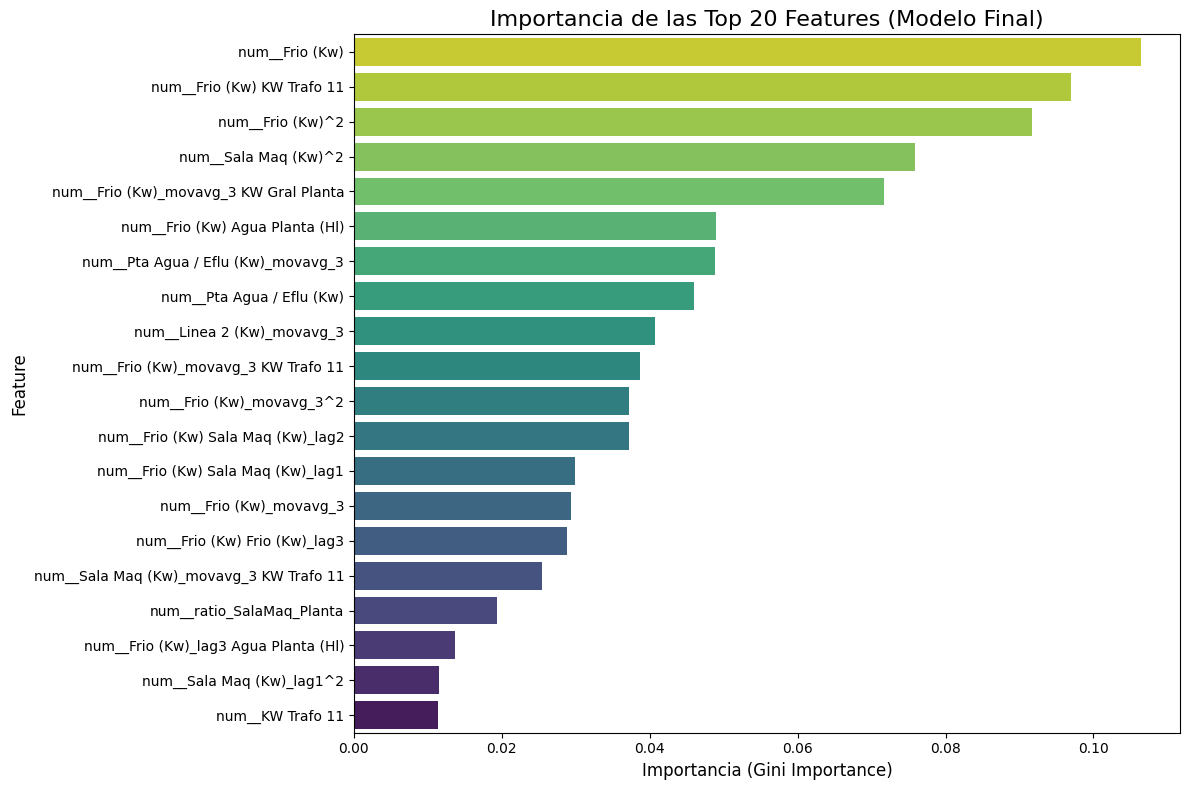

In [ ]:
print("\n--- Generando Gráfico de Importancia de Features Global ---")

# --- 1. Obtener los mejores hiperparámetros ---
best_params = study_rf_mae.best_params
print(f"Entrenando modelo final con params: {best_params}")

# --- 2. Entrenar el modelo final con los mejores parámetros ---
# Usamos RandomForestRegressor, ya que el estudio se llama 'study_rf_mae'
final_model = RandomForestRegressor(**best_params)
final_model.fit(X_train, y_train)

print("Modelo final entrenado.")

# --- 3. Obtener y estructurar la importancia de features ---
try:
    importances = final_model.feature_importances_
    feature_names = X_train.columns

    # Crear un DataFrame para graficar
    importance_df = pd.DataFrame({
        "feature": feature_names,
        "importance": importances
    })

    # Ordenar por importancia (de mayor a menor)
    importance_df = importance_df.sort_values(by="importance", ascending=False)
    
    # --- 4. Graficar (mostramos solo las Top 20 por legibilidad) ---
    N_TOP_FEATURES = 20
    if len(importance_df) > N_TOP_FEATURES:
        plot_df = importance_df.head(N_TOP_FEATURES)
        plot_title = f"Importancia de las Top {N_TOP_FEATURES} Features (Modelo Final)"
    else:
        plot_df = importance_df
        plot_title = "Importancia de Features (Modelo Final)"

    plt.figure(figsize=(12, 8)) # Ajusta el tamaño según sea necesario
    sns.barplot(
        x="importance", 
        y="feature", 
        data=plot_df, 
        palette="viridis_r" # Paleta de color invertida para variar
    )
    plt.title(plot_title, fontsize=16)
    plt.xlabel("Importancia (Gini Importance)", fontsize=12)
    plt.ylabel("Feature", fontsize=12)
    plt.tight_layout()
    plt.show()

except AttributeError as e:
    print(f"\nError: {e}")
    print("Asegúrate de que 'X_train' sea un DataFrame de Pandas para poder extraer los nombres de las columnas.")
except NameError:
    print("\nError: No se encontraron 'X_train' o 'y_train' en el scope.")